# Exploratory data analysis of todostuslibros.com book data

This notebooks reads scraped book data from the site www.todostuslibros.com and performs an exploratory data analysis of the available features. 

## Description of the data

The [scrapy project](https://github.com/ladywithanermine/ermine-book-data-scraping) used to crawl the data generates a JSON file for a list of aggregated categories (genres) from the site:

- Modern literary fiction
- Mistery and crime
- Suspense and terror
- Science fiction
- Historical fiction
- Romance

The structure of the generated JSON files is the following:

- **title**: title of the book.
- **author**: author(s) of the book.
- **publisher**: publishing house.
- **isbn**: international standard book number [ISBN](https://en.wikipedia.org/wiki/International_Standard_Book_Number).
- **price**: price of the book in Euros.
- **binding**: type of binding/edition. This feature includes hardcover, paperback, e-books, etc.
- **publishing_country**: country where this edition of the book was published.
- **publishing_language**: language of this edition of the book.
- **original_language**: original language of the book.
- **ean**: European Article Number [EAN](https://es.wikipedia.org/wiki/European_Article_Number).
- **publication_date**: date of publication (dd/MM/YYYY).
- **num_pages**: number of pages.
- **img_url**: URL for the cover image.
- **tags**: tags associated to the book in the website. They may refer to the genre, but also to the language (if it is not Spanish) or other custom categories.
- **bookstores_number**: number of bookstores where the book if available, at the time of the crawling. The bookstores used for the count are those affiliated to the Cegal association and they are listed [here](https://www.todostuslibros.com/librerias).
- **synopsis**: book synopsis and/or blurbs.

There are several things to take into account before diving in the data:

- Some books may belong to more than one category ('literary fiction' and 'crime', for instance). The crawler has gathered data for a list of identified genres, but some books may be associated with other genres not in the crawling list of fiction, mistery/crime, terror/suspense, science fiction, fantasy, historical fiction and romance.
- The taxonomy of the list of tags, binding types and other categorical data is not know (it is not documented on the site). It will thus be inferred from the data itself. A quick preliminary study performed while developing the crawler showed that some tags have very similar names. This is consistent with the hypothesis that category tags are assigned by free writing labels (either they don't come from a predesigned taxonomy or the taxonomy has freely evolved over time).

## Imports

In [474]:
import glob
import pandas as pd
from datetime import datetime
import re
from wordcloud import WordCloud

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline

## Read the data
We will read all the JSON files and join them in a single pandas dataframe to perform the analysis.

In [475]:
file_pattern = '../data/todostuslibros_*.json'
json_files = glob.glob(file_pattern)
json_files

['../data/todostuslibros_fiction.json',
 '../data/todostuslibros_mistery_crime.json',
 '../data/todostuslibros_scifi.json',
 '../data/todostuslibros_terror_suspense.json',
 '../data/todostuslibros_fantasy.json',
 '../data/todostuslibros_historical_fiction.json',
 '../data/todostuslibros_romance.json']

In [476]:
df = pd.DataFrame()

for json_file in json_files:
    cat_name = re.findall(r'..\/data\/todostuslibros_(.*).json', json_file)[0]
    df_json = pd.read_json(json_file, orient='records')
    #df_json.loc[:, 'aggregation'] = cat_name
    df = df.append(df_json)
    
df.head()

,title,author,publisher,isbn,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,tags,bookstores_number,synopsis
0,Estrellas negras,"Kapuscinski, Ryszard",Editorial Anagrama,9788433936929,NaN,Libro electrónico,España,Español,Polish,9788433936929,17-02-2016,224.0,https://static.cegal.es/imagenes/marcadas/9788...,[Ficción moderna y contemporanea],0,NaN
1,Locos de cine y otros relatos,"Pérez Rubio, Pablo",Editorial la Fragua del Trovador,9788415044758,NaN,Tapa blanda o Bolsillo,España,Español,Español,9788415044758,25-03-2017,176.0,None,[Ficción moderna y contemporanea],0,NaN
2,Pasiones romanas,"Janer, Maria de la Pau",Editorial Planeta,9788408063117,21.00,Cartoné,España,Español,Español,9788408063117,08-11-2005,452.0,https://static.cegal.es/imagenes/marcadas/9788...,[Ficción moderna y contemporanea],9,NaN
3,Los 7 soles de la felicidad,"Sanz Cañas, Esther",Umbriel,9788489367920,5.95,Tapa blanda o Bolsillo,España,Español,,9788489367920,07-02-2011,288.0,https://static.cegal.es/imagenes/marcadas/9788...,[Ficción moderna y contemporanea],1,NaN
4,Pack don Quijote + invitación al Quijote,AA. VV.,Lunwerg Editores,9788497851756,9.95,Cartoné,España,Español,,9788497851756,29-05-2007,1544.0,https://static.cegal.es/imagenes/marcadas/9788...,"[Ficción moderna y contemporanea, Ficción clás...",0,NaN


In [477]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135285 entries, 0 to 18310
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   title                135285 non-null  object 
 1   author               134095 non-null  object 
 2   publisher            135285 non-null  object 
 3   isbn                 135285 non-null  int64  
 4   price                66179 non-null   float64
 5   binding              127452 non-null  object 
 6   publishing_country   135285 non-null  object 
 7   publishing_language  135285 non-null  object 
 8   original_language    135285 non-null  object 
 9   ean                  135285 non-null  int64  
 10  publication_date     135285 non-null  object 
 11  num_pages            115764 non-null  float64
 12  img_url              101319 non-null  object 
 13  tags                 135285 non-null  object 
 14  bookstores_number    135285 non-null  int64  
 15  synopsis          

### Duplicates
Before starting the detailed analysis, we will check the number of duplicates, as it is possible that a book features in one or more of the searches based in genre. In order to compare all columns, including the `tags` list, we will momentarily convert `tags` to a string type.

In [478]:
df.loc[:, 'tags'] = df['tags'].apply(lambda x: ','.join(map(str, x)))
df.head(5)

,title,author,publisher,isbn,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,tags,bookstores_number,synopsis
0,Estrellas negras,"Kapuscinski, Ryszard",Editorial Anagrama,9788433936929,NaN,Libro electrónico,España,Español,Polish,9788433936929,17-02-2016,224.0,https://static.cegal.es/imagenes/marcadas/9788...,Ficción moderna y contemporanea,0,NaN
1,Locos de cine y otros relatos,"Pérez Rubio, Pablo",Editorial la Fragua del Trovador,9788415044758,NaN,Tapa blanda o Bolsillo,España,Español,Español,9788415044758,25-03-2017,176.0,None,Ficción moderna y contemporanea,0,NaN
2,Pasiones romanas,"Janer, Maria de la Pau",Editorial Planeta,9788408063117,21.00,Cartoné,España,Español,Español,9788408063117,08-11-2005,452.0,https://static.cegal.es/imagenes/marcadas/9788...,Ficción moderna y contemporanea,9,NaN
3,Los 7 soles de la felicidad,"Sanz Cañas, Esther",Umbriel,9788489367920,5.95,Tapa blanda o Bolsillo,España,Español,,9788489367920,07-02-2011,288.0,https://static.cegal.es/imagenes/marcadas/9788...,Ficción moderna y contemporanea,1,NaN
4,Pack don Quijote + invitación al Quijote,AA. VV.,Lunwerg Editores,9788497851756,9.95,Cartoné,España,Español,,9788497851756,29-05-2007,1544.0,https://static.cegal.es/imagenes/marcadas/9788...,"Ficción moderna y contemporanea,Ficción clásica",0,NaN


Full duplicate rows may arise due to reruns of the crawling process. We eliminate them before carrying on to check duplicates related to other columns:

In [479]:
'There are a total of {} duplicate rows in the dataset'.format(df.shape[0] - df.drop_duplicates().shape[0])

'There are a total of 7590 duplicate rows in the dataset'

In [480]:
df.drop_duplicates(inplace=True)
df.shape

(127695, 16)

In [481]:
'Confirm that, after removing duplicates, there are {} duplicate rows in the dataset'.format(df.shape[0] - df.drop_duplicates().shape[0])

'Confirm that, after removing duplicates, there are 0 duplicate rows in the dataset'

#### Identifying the causes for duplicate ISBN values

Titles appearing more than once may refer to different editions of the same book (hardcover, paperback, e-book, different languages, etc.). However, the ISBN code should be unique for each edition. A group by operation plus a count shows this is actually not the case:

In [482]:
df.groupby('isbn').count().reset_index().query('title>1')

,isbn,title,author,publisher,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,tags,bookstores_number,synopsis
33,9780008154226,2,2,2,0,0,2,2,2,2,2,2,2,2,2,0
105,9780062326904,2,2,2,2,2,2,2,2,2,2,0,2,2,2,0
111,9780062845740,2,2,2,2,2,2,2,2,2,2,0,2,2,2,0
121,9780099511021,2,2,2,2,0,2,2,2,2,2,2,2,2,2,0
229,9780244487102,2,2,2,2,2,2,2,2,2,2,0,2,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115890,9791220104265,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0
115904,9791220105354,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0
115920,9791220108089,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0
115944,9798663009874,2,2,2,0,0,2,2,2,2,2,0,0,2,2,0


Let's check a few examples to find out what the problem may be:

The following ISBN number appears twice in the dataset. The author, publisher and country are the same, but it is interesting to notice that the publishing language and original language are different: 'Español' and 'Castellano'. Both languages are actually the same, so the two rows can be considered duplicates. 

In [483]:
df.query('isbn == 9780008154226')

,title,author,publisher,isbn,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,tags,bookstores_number,synopsis
6107,Carrying albert home,Hickam Homer,HarperCollins,9780008154226,NaN,None,España,Español,Español,9780008154226,01-01-2016,395.0,https://static.cegal.es/imagenes/marcadas/9780...,Ficción moderna y contemporanea,0,NaN
65916,Carrying albert home,Hickam Homer,HarperCollins,9780008154226,NaN,None,España,Castellano,Castellano,9780008154226,01-01-2016,395.0,https://static.cegal.es/imagenes/marcadas/9780...,Ficción moderna y contemporanea,0,NaN


Another example is the following book by the popular Agatha Christie. It has several different editions (paperback, e-book, audiobook) with different ISBN numbers and multiple tags/genres. The problem with the publishing language 'Español' and 'Castellano' also appears here. It could be caused by a manual upload of the book details to the website, or maybe to a change in the language taxonomy. As it is not possible for us to know, we will unify both labels into 'Castellano'.

Besides, there is a difference in the number of bookstores where the same book/ISBN is available (see the 2nd and 3rd rows, for example). This may have arisen due to the sequential crawling process: a book crawled a day for one genre and on the next day for a second (complementary) genre may have different availability if some items have been sold at any of the affiliated bookshops. Thus, the `bookstores_number` feature should not be taken into account for the duplicates check.

In [484]:
df.query('title == "La casa torcida"').sort_values(by='isbn')

,title,author,publisher,isbn,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,tags,bookstores_number,synopsis
415,La casa torcida,"Christie, Agatha",Espasa,9788467050554,14.90,Tapa blanda o Bolsillo,España,Español,Inglés,9788467050554,03-10-2017,240.0,https://static.cegal.es/imagenes/marcadas/9788...,"Ficción moderna y contemporanea,Género policía...",237,NaN
74973,La casa torcida,"Christie, Agatha",Espasa,9788467050554,14.90,Tapa blanda o Bolsillo,España,Castellano,Inglés,9788467050554,03-10-2017,240.0,https://static.cegal.es/imagenes/marcadas/9788...,"Ficción moderna y contemporanea,Género policía...",239,NaN
2557,La casa torcida,"Christie, Agatha",Espasa,9788467050554,14.90,Tapa blanda o Bolsillo,España,Castellano,Inglés,9788467050554,03-10-2017,240.0,https://static.cegal.es/imagenes/marcadas/9788...,"Ficción moderna y contemporanea,Género policía...",238,Tres generaciones de la familia del multimill...
8767,La casa torcida,"Christie, Agatha",Espasa,9788467050820,NaN,Libro electrónico,España,Español,Inglés,9788467050820,03-10-2017,240.0,https://static.cegal.es/imagenes/marcadas/9788...,"Ficción moderna y contemporanea,Género policía...",0,NaN
50199,La casa torcida,"Christie, Agatha",Espasa,9788467050820,NaN,Libro electrónico,España,Castellano,Inglés,9788467050820,03-10-2017,240.0,https://static.cegal.es/imagenes/marcadas/9788...,"Ficción moderna y contemporanea,Género policía...",0,NaN
268,La casa torcida,"Christie, Agatha",Espasa,9788467050820,NaN,Libro electrónico,España,Castellano,Inglés,9788467050820,03-10-2017,240.0,https://static.cegal.es/imagenes/marcadas/9788...,"Ficción moderna y contemporanea,Género policía...",0,Tres generaciones de la familia del multimill...
51906,La casa torcida,"Christie, Agatha",Booket,9788467051643,8.95,Tapa blanda o Bolsillo,España,Castellano,Inglés,9788467051643,05-04-2018,240.0,https://static.cegal.es/imagenes/marcadas/9788...,Ficción moderna y contemporanea,173,NaN
985,La casa torcida,"Christie, Agatha",Espasa,9788467052268,NaN,Archivo de audio descargable,España,Castellano,Inglés,9788467052268,25-04-2018,NaN,https://static.cegal.es/imagenes/marcadas/9788...,"Ficción moderna y contemporanea,Género policía...",0,Tres generaciones de la familia del multimill...
1591,La casa torcida,"CHRISTIE , AGATHA",RBA Libros,9788492966370,NaN,Libro electrónico,España,Castellano,Inglés,9788492966370,01-09-2010,256.0,https://static.cegal.es/imagenes/marcadas/9788...,Clásicos policíacos,0,Tres generaciones de la familia de Arístides ...


#### Unifying 'Español' and 'Castellano' as a single language

In [485]:
df[['publishing_language', 'original_language']] = df[['publishing_language', 'original_language']].replace('Español', 'Castellano')
df.head()

,title,author,publisher,isbn,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,tags,bookstores_number,synopsis
0,Estrellas negras,"Kapuscinski, Ryszard",Editorial Anagrama,9788433936929,NaN,Libro electrónico,España,Castellano,Polish,9788433936929,17-02-2016,224.0,https://static.cegal.es/imagenes/marcadas/9788...,Ficción moderna y contemporanea,0,NaN
1,Locos de cine y otros relatos,"Pérez Rubio, Pablo",Editorial la Fragua del Trovador,9788415044758,NaN,Tapa blanda o Bolsillo,España,Castellano,Castellano,9788415044758,25-03-2017,176.0,None,Ficción moderna y contemporanea,0,NaN
2,Pasiones romanas,"Janer, Maria de la Pau",Editorial Planeta,9788408063117,21.00,Cartoné,España,Castellano,Castellano,9788408063117,08-11-2005,452.0,https://static.cegal.es/imagenes/marcadas/9788...,Ficción moderna y contemporanea,9,NaN
3,Los 7 soles de la felicidad,"Sanz Cañas, Esther",Umbriel,9788489367920,5.95,Tapa blanda o Bolsillo,España,Castellano,,9788489367920,07-02-2011,288.0,https://static.cegal.es/imagenes/marcadas/9788...,Ficción moderna y contemporanea,1,NaN
4,Pack don Quijote + invitación al Quijote,AA. VV.,Lunwerg Editores,9788497851756,9.95,Cartoné,España,Castellano,,9788497851756,29-05-2007,1544.0,https://static.cegal.es/imagenes/marcadas/9788...,"Ficción moderna y contemporanea,Ficción clásica",0,NaN


In [486]:
'Duplicate books after unifying Español/Castellano: {}'.format(df.shape[0] - df.drop_duplicates().shape[0])

'Duplicate books after unifying Español/Castellano: 5938'

In [487]:
df.drop_duplicates(inplace=True)
df.shape

(121757, 16)

Let's repeat the previous sample query to verify that only one edition (ISBN) of the book is available now, as expected:

In [488]:
df.query('isbn == 9780008154226')

,title,author,publisher,isbn,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,tags,bookstores_number,synopsis
6107,Carrying albert home,Hickam Homer,HarperCollins,9780008154226,NaN,None,España,Castellano,Castellano,9780008154226,01-01-2016,395.0,https://static.cegal.es/imagenes/marcadas/9780...,Ficción moderna y contemporanea,0,NaN


#### Duplicates based only on catalog columns
Let's check the number of duplicates only for the basic catalog columns title, author, publisher and ISBN code:

In [489]:
taxonomy_columns = ['title', 'author', 'publisher', 'isbn']

In [490]:
df.drop_duplicates(subset = taxonomy_columns, inplace=True)
'Unique books after dropping duplicates on catalog columns: {}'.format(df.shape[0])

'Unique books after dropping duplicates on catalog columns: 115960'

Let's recheck the Agatha Christie example. The result now should be just one row by ISBN number:

In [491]:
df.query('title == "La casa torcida"').sort_values(by='isbn')

,title,author,publisher,isbn,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,tags,bookstores_number,synopsis
415,La casa torcida,"Christie, Agatha",Espasa,9788467050554,14.90,Tapa blanda o Bolsillo,España,Castellano,Inglés,9788467050554,03-10-2017,240.0,https://static.cegal.es/imagenes/marcadas/9788...,"Ficción moderna y contemporanea,Género policía...",237,NaN
8767,La casa torcida,"Christie, Agatha",Espasa,9788467050820,NaN,Libro electrónico,España,Castellano,Inglés,9788467050820,03-10-2017,240.0,https://static.cegal.es/imagenes/marcadas/9788...,"Ficción moderna y contemporanea,Género policía...",0,NaN
51906,La casa torcida,"Christie, Agatha",Booket,9788467051643,8.95,Tapa blanda o Bolsillo,España,Castellano,Inglés,9788467051643,05-04-2018,240.0,https://static.cegal.es/imagenes/marcadas/9788...,Ficción moderna y contemporanea,173,NaN
985,La casa torcida,"Christie, Agatha",Espasa,9788467052268,NaN,Archivo de audio descargable,España,Castellano,Inglés,9788467052268,25-04-2018,NaN,https://static.cegal.es/imagenes/marcadas/9788...,"Ficción moderna y contemporanea,Género policía...",0,Tres generaciones de la familia del multimill...
1591,La casa torcida,"CHRISTIE , AGATHA",RBA Libros,9788492966370,NaN,Libro electrónico,España,Castellano,Inglés,9788492966370,01-09-2010,256.0,https://static.cegal.es/imagenes/marcadas/9788...,Clásicos policíacos,0,Tres generaciones de la familia de Arístides ...


Let's check the number of unique ISBNs by group as before, to further verify that all ISBN duplicates have been removed:

In [492]:
remaining_duplicates = df.groupby('isbn').count().reset_index().query('title>1')
remaining_duplicates

,isbn,title,author,publisher,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,tags,bookstores_number,synopsis
47340,9788418544965,2,2,2,2,1,2,2,2,2,2,1,2,2,2,1
64002,9788466324168,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1
64061,9788466326322,2,2,2,1,2,2,2,2,2,2,2,2,2,2,1
79208,9788483077184,2,2,2,1,2,2,2,2,2,2,2,2,2,2,0
79242,9788483077702,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0


There are still a few ISBN duplicates that we can check manually, as the number is small. A visual check reveals that these last duplicates relate to text formatting in the `title`, `author` and `publisher`columns. All the differences in the `publisher` column come from using uppercase or lowercase/Camel case. The `title` column shows a more complicated case, related to subtitle or edition information that is present in some rows. In the `author` column there is a mixture of different case formats and author style listing ("surname, name" or "name, surname").

As there is not a clear rule for titles and authors, those cases should be corrected manually. For publishers, an option would be, for instance, to unify all texts to uppercase and drop duplicates again.

The case of ISBN 9788466326322 is a special one, as the title includes information on the binding that is not actually present in the `binding` column. The binding specified is just 'Libro' which does not relate to hardcover/paperback or other specific edition. Thus, manual correction will include the update of the binding column in this case.

In [493]:
df[df['isbn'].isin(remaining_duplicates.isbn)].sort_values(by='isbn')

,title,author,publisher,isbn,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,tags,bookstores_number,synopsis
39151,CUANDO EL DRAGÓN AMENAZÓ LA BAHÍA,"DE LA CAMPA MUÑOZ,JENARO",EDITORIAL ADARVE,9788418544965,18.00,None,España,Castellano,Castellano,9788418544965,01-02-2021,NaN,https://static.cegal.es/imagenes/marcadas/9788...,Ficción moderna y contemporanea,207,NaN
870,Cuando el dragón amenazó la bahía,"de la Campa Muñoz, Jenaro",Editorial Adarve,9788418544965,18.00,Tapa blanda o Bolsillo,España,Castellano,Castellano,9788418544965,09-02-2021,272.0,https://static.cegal.es/imagenes/marcadas/9788...,Ficción histórica,205,"Cuando en el año 1585 Sir Francis Drake, apod..."
42326,HERMANOS DE SANGRE FG,"Roberts, Nora",PUNTO DE LECTURA,9788466324168,9.99,Libro,España,Castellano,,9788466324168,11-05-2010,416.0,https://static.cegal.es/imagenes/marcadas/9788...,"Ficción moderna y contemporanea,Obra de mister...",3,NaN
4151,Hermanos de sangre (Trilogía Signo del Siete 1),"Roberts, Nora",PUNTO DE LECTURA,9788466324168,9.99,Libro,España,Castellano,,9788466324168,11-05-2010,416.0,https://static.cegal.es/imagenes/marcadas/9788...,"Ficción moderna y contemporanea,Obra de mister...",3,No te pierdas la primera entrega de la trilog...
8877,Caperucita Roja. ¿A quién tienes miedo? (bolsi...,"Blakley-Cartwright, Sarah",PUNTO DE LECTURA,9788466326322,NaN,Libro,España,Castellano,Inglés,9788466326322,05-09-2012,368.0,https://static.cegal.es/imagenes/marcadas/9788...,"Ficción moderna y contemporanea,Ficción clásic...",0,NaN
16947,Caperucita Roja. ¿A quién tienes miedo?,"Blakley-Cartwright, Sarah",PUNTO DE LECTURA,9788466326322,8.99,Libro,España,Castellano,Inglés,9788466326322,05-09-2012,368.0,https://static.cegal.es/imagenes/marcadas/9788...,"Narrativa romántica,Ficción clásica,Ficción mo...",0,"La campana de la aldea dobla una, dos, tres v..."
7458,¿Por qué los hombres tienen pezones?,"Leyner, Mark / Goldberg, Billy / Billy, Goldberg",Ediciones Península,9788483077184,NaN,Tapa blanda o Bolsillo,España,Castellano,,9788483077184,01-02-2006,208.0,https://static.cegal.es/imagenes/marcadas/9788...,Ficción moderna y contemporanea,0,NaN
75007,¿Por qué los hombres tienen pezones?,"Leyner, Mark / Goldberg, Billy / Goldberg, Billy",Ediciones Península,9788483077184,17.30,Tapa blanda o Bolsillo,España,Castellano,,9788483077184,01-02-2006,208.0,https://static.cegal.es/imagenes/marcadas/9788...,Ficción moderna y contemporanea,0,NaN
7459,¿Por qué los hombres se duermen después de dar...,"Leyner, Mark / Goldberg, Billy / Billy, Goldberg",Ediciones Península,9788483077702,17.30,Tapa blanda o Bolsillo,España,Castellano,Inglés,9788483077702,13-02-2007,256.0,https://static.cegal.es/imagenes/marcadas/9788...,Ficción moderna y contemporanea,1,NaN
75006,¿Por qué los hombres se duermen después de dar...,"Leyner, Mark / Goldberg, Billy / Goldberg, Billy",Ediciones Península,9788483077702,17.30,Tapa blanda o Bolsillo,España,Castellano,Inglés,9788483077702,13-02-2007,256.0,https://static.cegal.es/imagenes/marcadas/9788...,Ficción moderna y contemporanea,1,NaN


Manual correction of the remaining duplicates:

In [494]:
df.loc[df['isbn']==9788418544965, 'title'] = 'Cuando el dragón amenazó la bahía'
df.loc[df['isbn']==9788418544965, 'author'] = 'de la Campa Muñoz, Jenaro'
df.loc[df['isbn']==9788418544965, 'publisher'] = 'Editorial Adarve'

df.loc[df['isbn']==9788466324168, 'title'] = 'Hermanos de sangre (Trilogía Signo del Siete 1)'

df.loc[df['isbn']==9788466326322, 'title'] = 'Caperucita Roja. ¿A quién tienes miedo?'
df.loc[df['isbn']==9788466326322, 'binding'] = 'Tapa blanda o Bolsillo'

df.loc[df['isbn']==9788483077184, 'author'] = 'Leyner, Mark / Goldberg, Billy / Goldberg, Billy'

df.loc[df['isbn']==9788483077702, 'author'] = 'Leyner, Mark / Goldberg, Billy / Goldberg, Billy'

In [495]:
df.drop_duplicates(subset = taxonomy_columns, inplace=True)
'Unique books after manual correction of remaining duplicates: {}'.format(df.shape[0])

'Unique books after manual correction of remaining duplicates: 115955'

The last check on duplicate taxonomy columns gives us the expected empty dataset. Thus, we can confirm that we have removed all duplicates and we may continue with the exploratory analysis:

In [496]:
remaining_duplicates = df.groupby('isbn').count().reset_index().query('title>1')
df[df['isbn'].isin(remaining_duplicates.isbn)].sort_values(by='isbn')

,title,author,publisher,isbn,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,tags,bookstores_number,synopsis


### Format data types
Most of the columns from the dataset are related to descriptive qualities (thus, qualitative features), such as the type of binding, the publishing country or the language, etc. Numerical features include the `price` and the `bookstores_number`. Special cases are:

- The `isbn` or [International Standard Book Number](https://en.wikipedia.org/wiki/International_Standard_Book_Number) is a unique identifier and it could be an appropriate index for the dataframe, once we have checked there are no duplicates. We will convert it to string, as it is not additive, nor it represents a numeric variable.
- The `ean` column relates to the [European Article Number](https://en.wikipedia.org/wiki/International_Article_Number) system. In 2007, a 13 digit ISBN number system was deployed, in order to match the EAN system. Thus, we would expect the ISBN column to have the same values as the EAN.
- The `tags` column includes all tags associated with the book in the website as a list.
- The `publication_date` is a date string with the format dd/MM/YYYY. When converting the string to timestamp, an exception is thrown for empty string values, so it's necessary to include a condition to transform empty strings to NaN.
- The `num_pages` column is read directly as a float but the number of pages variable should be considered as an integer. Thus, we will change the column data type.

Besides the conversions above, we will convert all string columns into the explicit String DType for explicit declaration of the data types, and we will split the `tags` column back to the list format.

In [501]:
df.loc[:, 'isbn'] = df.isbn.astype('string')
df.loc[:, 'ean'] = df.ean.astype('string')
df.loc[:, 'publication_date'] = df.publication_date.apply(lambda x: datetime.strptime(x, '%d-%m-%Y') if x else None)
df.loc[:, 'num_pages'] = df.num_pages.astype('Int64')
df.loc[:, 'bookstores_number'] = df.bookstores_number.astype('Int64')
df.loc[:, 'tags'] = df.tags.apply(lambda x: x.split(','))

In [502]:
string_columns = ['title', 'author', 'publisher', 'binding', 'publishing_country', 'publishing_language', 'original_language', 'img_url', 'synopsis']
for string_col in string_columns:
    df.loc[:, string_col] = df[string_col].astype('string')

In [503]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115955 entries, 0 to 18306
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   title                115955 non-null  string        
 1   author               114948 non-null  string        
 2   publisher            115955 non-null  string        
 3   isbn                 115955 non-null  string        
 4   price                55745 non-null   float64       
 5   binding              109321 non-null  string        
 6   publishing_country   115955 non-null  string        
 7   publishing_language  115955 non-null  string        
 8   original_language    115955 non-null  string        
 9   ean                  115955 non-null  string        
 10  publication_date     114657 non-null  datetime64[ns]
 11  num_pages            99248 non-null   Int64         
 12  img_url              86283 non-null   string        
 13  tags           

## Exploratory data analysis
The exploratory data analysis will start by looking at the numerical and categorical features independently, to proceed with the study of the relationships between features (correlation, etc.) in the 'Multivariate analysis' section.

In [504]:
types_df = df.dtypes.reset_index()
types_df.rename(columns={0: "type"}, inplace=True)

### Univariate analysis

#### Numerical features
The dataset has only 3 numerical features:

- `price`
- `num_pages`
- `bookstores_number`


In [511]:
quantitative_vars_df = types_df[(types_df['type']=='float64') | (types_df['type']=='Int64')]
quantitative_vars = list(quantitative_vars_df['index'].to_numpy())
quantitative_vars

['price', 'num_pages', 'bookstores_number']

In [512]:
quantitative_df = df.loc[:, quantitative_vars]
quantitative_df.head()

,price,num_pages,bookstores_number
0,NaN,224,0
1,NaN,176,0
2,21.00,452,9
3,5.95,288,1
4,9.95,1544,0


##### General view
The basic pandas statistics provide general insights into the three numerical variables of the dataset. 

The `bookstores_number` feature has information for all the books in the dataset, as it is generated during the crawling process (if the book is not available at any bookshop, the crawler assigns 0 to this feature). On ther other hand, `price` and `num_pages` are crawled directly from the book page. The null count shows that more than 50% of the books have no information regarding their price. For the number of pages, around 85% of the books have information. 

It will be interesting to dive in these features and their relationship with, for instance, publication date or even publication country. For some very old books, inventory information may not be available to provide for the price (if the book has not been available in shops for a long time) or the number of pages.

In [513]:
quantitative_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115955 entries, 0 to 18306
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              55745 non-null   float64
 1   num_pages          99248 non-null   Int64  
 2   bookstores_number  115955 non-null  Int64  
dtypes: Int64(2), float64(1)
memory usage: 3.8 MB


In [514]:
quantitative_df.describe()

,price,num_pages,bookstores_number
count,55745.000000,99248.000000,115955.000000
mean,14.999703,304.537653,52.656556
std,6.901544,181.480746,88.437608
min,0.010000,1.000000,0.000000
25%,9.950000,176.000000,0.000000
50%,15.000000,278.000000,0.000000
75%,18.950000,388.000000,80.000000
max,226.920000,6121.000000,555.000000


The `price` distibution is centered around 15€ with a short tail towards the 200€ and the `num_pages`, around 280 pages, with a short tail of very long books. It will be interesting to study ahead (see Multivariate analysis) the dependency between the number of pages and some categorical variables, such as type of binding or 'genre', as expressed in the `aggregation` or in the `tags` column. 

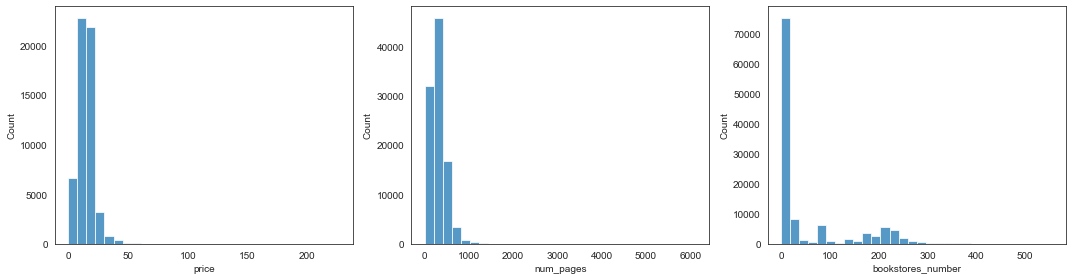

In [515]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
for col, ax in zip(quantitative_vars, axes):
    sns.histplot(quantitative_df[col], bins=30, ax=ax)

plt.tight_layout() 
plt.show();

The boxplots provide a different view into the same findings: some 'outliers' with more than 1000 pages and prices over 100€. The three distributions include only values equal or over zero.

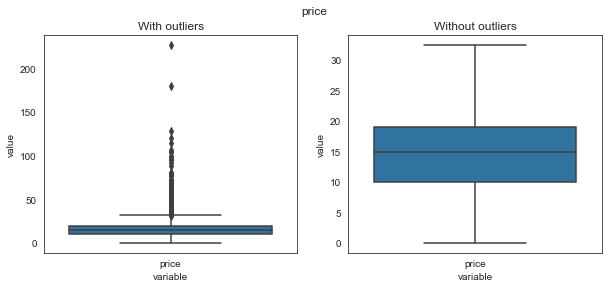

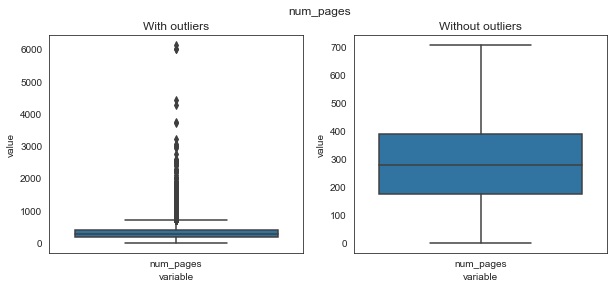

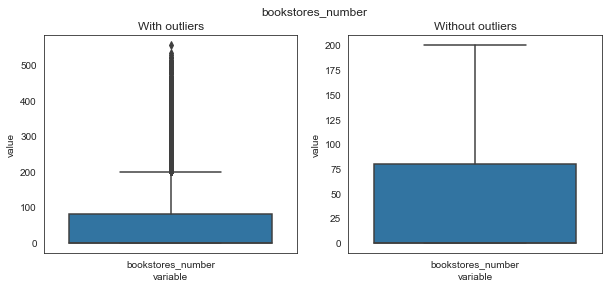

In [516]:
quant_melted = pd.melt(quantitative_df)
quant_melted.loc[:, 'value'] = pd.to_numeric(quant_melted.value)

for quant_var in quantitative_vars:
    quant_var_data = quant_melted[quant_melted['variable']==quant_var]
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.boxplot(x="variable", y="value", data=quant_var_data, ax=axes[0]).set_title('With outliers')
    sns.boxplot(x="variable", y="value", data=quant_var_data, showfliers = False, ax=axes[1]).set_title('Without outliers');
    fig.suptitle(quant_var)

##### Zoom into: bookstores number
A quick look at the distribution via the histogram or the percentiles shows that many books are available at very few shops (the 25% percentile is 2!). It is useful to take a look at the `bookstores_number` distribution removing values under the 25% percentile in order to find out that it is approximately centered around 240 bookstores, with a long tail of books available at more than 300 or even 400 shops.

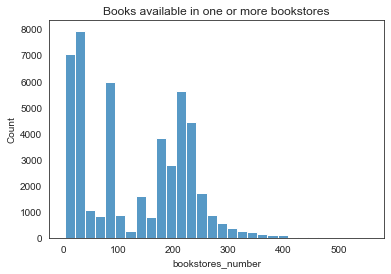

In [517]:
df_bookstores_number = df.loc[df['bookstores_number']>2, 'bookstores_number']
sns.histplot(df_bookstores_number, bins=30)
plt.title('Books available in one or more bookstores');

#### Qualitative features
Some of the categorical features, such as `title`, `author`, `img_url`, `synopsis` or `publisher`, have a great number of unique values (in the case of `title`, there could be duplicates related to different editions of the same text, such as hardcover and paperback). `isbn` and `ean`, on the other hand, are supposedly unique identifiers. 

A count of the unique values by column shows us the variability of some of the columns and how those are not suitable for a categorical analysis. Some things to notice are:

- The number of different titles is less than the number of ISBN codes. This may relate to the availability of different releases or editions for certain books. A count of bindings and publishing languages or publishers per book will clarify this point (see 'Multivariate analysis').
- The number of different ISBN and EAN codes is identical, thus reforcing the idea that ISBN = EAN. 
- There are 6520 different combinations of tags, but more than one tag may be assigned to a book. A zoom into the `tags` feature is necessary to further understand its details.
- The features that have a limited number of values and can thus be considered purely categorical are `binding`, `publishing_country`, `publishing_language` and `original_language`.

In [531]:
qualitative_vars_df = types_df[(types_df['type']=='string')]
qualitative_vars = list(qualitative_vars_df['index'].to_numpy())
qualitative_vars

['title',
 'author',
 'publisher',
 'isbn',
 'binding',
 'publishing_country',
 'publishing_language',
 'original_language',
 'ean',
 'img_url',
 'synopsis']

In [532]:
qualitative_df = df[qualitative_vars]
qualitative_df.head()

,title,author,publisher,isbn,binding,publishing_country,publishing_language,original_language,ean,img_url,synopsis
0,Estrellas negras,"Kapuscinski, Ryszard",Editorial Anagrama,9788433936929,Libro electrónico,España,Castellano,Polish,9788433936929,https://static.cegal.es/imagenes/marcadas/9788...,<NA>
1,Locos de cine y otros relatos,"Pérez Rubio, Pablo",Editorial la Fragua del Trovador,9788415044758,Tapa blanda o Bolsillo,España,Castellano,Castellano,9788415044758,<NA>,<NA>
2,Pasiones romanas,"Janer, Maria de la Pau",Editorial Planeta,9788408063117,Cartoné,España,Castellano,Castellano,9788408063117,https://static.cegal.es/imagenes/marcadas/9788...,<NA>
3,Los 7 soles de la felicidad,"Sanz Cañas, Esther",Umbriel,9788489367920,Tapa blanda o Bolsillo,España,Castellano,,9788489367920,https://static.cegal.es/imagenes/marcadas/9788...,<NA>
4,Pack don Quijote + invitación al Quijote,AA. VV.,Lunwerg Editores,9788497851756,Cartoné,España,Castellano,,9788497851756,https://static.cegal.es/imagenes/marcadas/9788...,<NA>


In [533]:
qualitative_df.nunique()

title                   88040
author                  53125
publisher                8398
isbn                   115955
binding                    29
publishing_country         29
publishing_language        45
original_language          67
ean                    115955
img_url                 86283
synopsis                31043
dtype: int64

The variables we could thus understand as *real* categorical features (belonging to a somewhat limited catalog of values) are the following:

- `binding`
- `publishing_country`
- `publishing_language`
- `original_language`

##### Purely categorical features

In [534]:
categorical_vars = ['binding', 'publishing_country', 'publishing_language', 'original_language']
categorical_df = df.loc[:, categorical_vars]
categorical_df.head()

,binding,publishing_country,publishing_language,original_language
0,Libro electrónico,España,Castellano,Polish
1,Tapa blanda o Bolsillo,España,Castellano,Castellano
2,Cartoné,España,Castellano,Castellano
3,Tapa blanda o Bolsillo,España,Castellano,
4,Cartoné,España,Castellano,


It is noticeable that there are no NaN values as such for these features, but all of them have occurrences with the empty string, which could be considered the None value for these features.

In the case of `publishing_language` and `original_language` it is also important to notice that the top two values are 'Español' and 'Castellano', that are in fact the same language. The value 'No determinado' (unspecified) for language could also be considered a NaN.

In [535]:
for catvar in categorical_vars:
    print('******** Value counts for feature:', catvar)
    print(categorical_df[catvar].value_counts())

******** Value counts for feature: binding
Tapa blanda o Bolsillo          65696
Libro electrónico               28519
Cartoné                          8006
Libro                            2929
                                 2733
Libro en otro formato             695
Archivo de audio descargable      403
Recurso en línea                  184
CD-Audio                           69
Piel / Lujo                        33
Espiral                            14
Folleto                             5
Disco audio                         4
CD-ROM                              4
Libro de tela                       4
Mapa en hojas                       3
Libro de cartón                     3
Carpeta                             3
Producto multisoporte               2
Película o transparencia            2
DVD Audio                           2
Audio                               1
Tarjetas                            1
Lámina                              1
Calendario                          1
Fascícu

##### Zoom into: Tags
Let's take a detailed of at the `tags` column and the individual tags frequencies.

Taking a look at the www.todostuslibros.com site lets us realize that tags are not only used for genres, but for language and a sort of subgenre specification as well. There is, for instance, a tag for "classical science fiction" and a different one for "science fiction" (presumably contemporary science fiction, although in the crawling process both have been stored and aggregated as plan "science fiction"), and some books are tagged with their original language, in most of the cases if it is not Spanish.

In [536]:
df_tags = df.explode('tags')
df_tags.head()

,title,author,publisher,isbn,price,binding,publishing_country,publishing_language,original_language,ean,publication_date,num_pages,img_url,tags,bookstores_number,synopsis
0,Estrellas negras,"Kapuscinski, Ryszard",Editorial Anagrama,9788433936929,NaN,Libro electrónico,España,Castellano,Polish,9788433936929,2016-02-17,224,https://static.cegal.es/imagenes/marcadas/9788...,Ficción moderna y contemporanea,0,<NA>
1,Locos de cine y otros relatos,"Pérez Rubio, Pablo",Editorial la Fragua del Trovador,9788415044758,NaN,Tapa blanda o Bolsillo,España,Castellano,Castellano,9788415044758,2017-03-25,176,<NA>,Ficción moderna y contemporanea,0,<NA>
2,Pasiones romanas,"Janer, Maria de la Pau",Editorial Planeta,9788408063117,21.00,Cartoné,España,Castellano,Castellano,9788408063117,2005-11-08,452,https://static.cegal.es/imagenes/marcadas/9788...,Ficción moderna y contemporanea,9,<NA>
3,Los 7 soles de la felicidad,"Sanz Cañas, Esther",Umbriel,9788489367920,5.95,Tapa blanda o Bolsillo,España,Castellano,,9788489367920,2011-02-07,288,https://static.cegal.es/imagenes/marcadas/9788...,Ficción moderna y contemporanea,1,<NA>
4,Pack don Quijote + invitación al Quijote,AA. VV.,Lunwerg Editores,9788497851756,9.95,Cartoné,España,Castellano,,9788497851756,2007-05-29,1544,https://static.cegal.es/imagenes/marcadas/9788...,Ficción moderna y contemporanea,0,<NA>


There is a total of 1104 unique tags, where the most common is 'Ficción moderna y contemporanea' (modern and contemporary fiction).

In [537]:
df_tags.tags.describe()

count                              168209
unique                               1104
top       Ficción moderna y contemporanea
freq                                68150
Name: tags, dtype: object

The 10 more frequent tags are these, followed by a tag wordcloud:

In [538]:
df_tags.tags.value_counts().iloc[:10]

Ficción moderna y contemporanea               68150
Narrativa romántica                           11470
Género policíaco y misterio                    9580
Narrativa romántica adulta y contemporánea     9442
Ficción histórica                              8479
Obra de misterio y suspense                    7035
Fantasía                                       6440
Español / Castellano                           6222
Ciencia Ficción                                5488
Cuentos de terror y fantasmas                  2386
Name: tags, dtype: int64

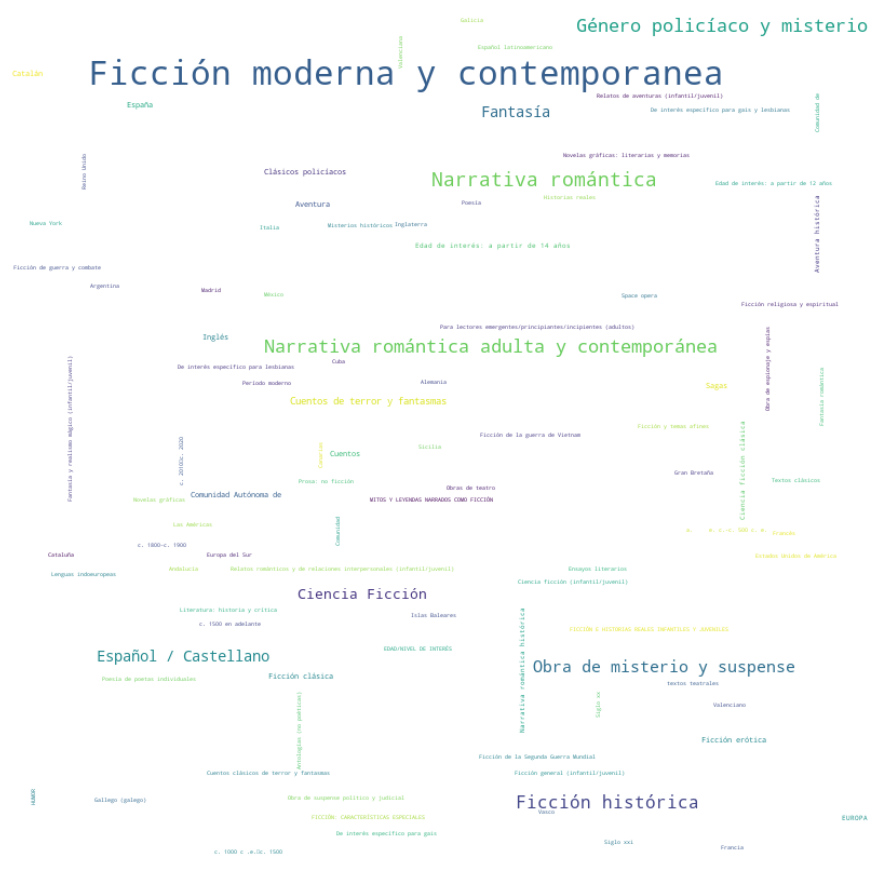

In [539]:
data = df_tags['tags'].value_counts().to_dict()
word_cloud = WordCloud(width = 800, height = 800, background_color='white', max_words=100).generate_from_frequencies(data)
plt.figure(figsize=(12, 12), facecolor = 'white', edgecolor='blue')
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(word_cloud, interpolation='bilinear')
plt.show()

#### Datetime features

##### Publication date

`publication_date` is the only datetime feature of the dataset. 

A study of this feature may allow us to investigate the number of books published by date (month/year), from an univariate point of view. If we take into account other features we may dive into the distribution of published books per genre and date/month/year and others (see the Multivariate analysis section).

In [540]:
df_datetime = df[['publication_date']].copy()
df_datetime.loc[:, 'day_of_month'] = df_datetime.publication_date.dt.day
df_datetime.loc[:, 'month'] = df_datetime.publication_date.dt.month
df_datetime.loc[:, 'year'] = df_datetime.publication_date.dt.year
df_datetime.head()

,publication_date,day_of_month,month,year
0,2016-02-17,17.0,2.0,2016.0
1,2017-03-25,25.0,3.0,2017.0
2,2005-11-08,8.0,11.0,2005.0
3,2011-02-07,7.0,2.0,2011.0
4,2007-05-29,29.0,5.0,2007.0


A pairplot of datetime-related variables gives us some insights into the distribution of books published by month. January and October are the months with more books published. October coincides with the classical literary *rentrée* after the summer.

The concentration of publication dates around 2019 is quite an indicative of the availability of just very recently published books in the bookshops. The Spanish book industry (as it's mostly the case around the globe) is one caracterized by its speed of change: a new book usually only lasts a few weeks on the 'new releases' shelves.

<Figure size 936x1152 with 0 Axes>

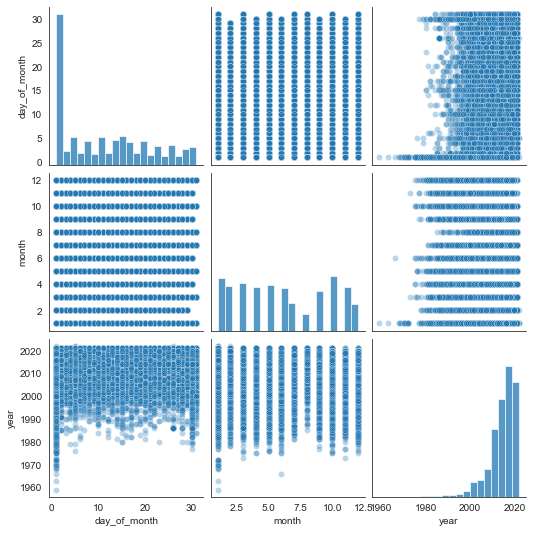

In [541]:
plt.figure(figsize=(13,16))
sns.pairplot(df_datetime, kind='scatter', diag_kind='hist', plot_kws={'alpha':0.3}, diag_kws={'bins':20});

In [542]:
df_datetime_grouped = df_datetime.groupby('publication_date').count()
df_datetime_grouped.head()

,day_of_month,month,year
publication_date,,,
1959-01-01,1,1,1
1963-01-01,1,1,1
1966-06-01,1,1,1
1968-01-01,2,2,2
1969-01-01,2,2,2


Here is a lineplot depicting the books by date time series:

<AxesSubplot:xlabel='publication_date', ylabel='month'>

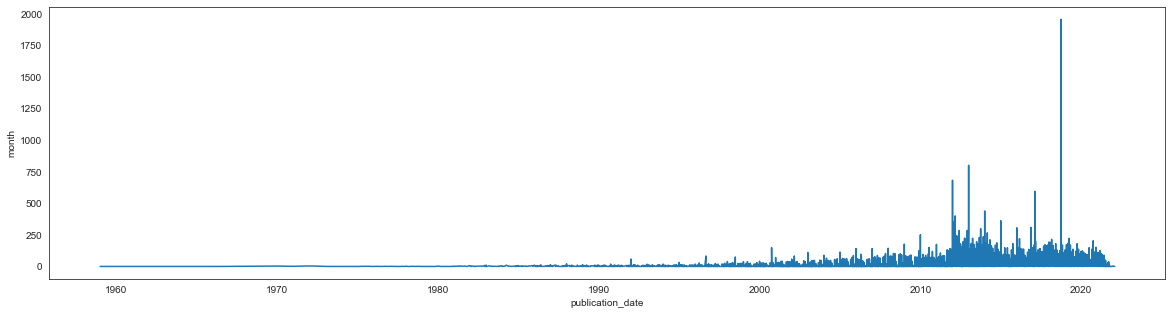

In [543]:
plt.figure(figsize=(20,5))
sns.lineplot(x='publication_date', y='month', data=df_datetime_grouped.reset_index())

The following plot studies the distribution of published books along the days of the month:

In [544]:
df_datetime_month = df_datetime.groupby(['month', 'day_of_month']).agg({'publication_date': 'count'}).reset_index()
df_datetime_month.head()

,month,day_of_month,publication_date
0,1.0,1.0,5231
1,1.0,2.0,151
2,1.0,3.0,111
3,1.0,4.0,147
4,1.0,5.0,141


A heatmap of published books by day of the month highlights what was already visible in the pairplot: most of the books published are released on the first day of the month. The second more important date in the month is around the 15th. This heatmap also shows the relevance of January and October for the book industry, followed by March. The summer months (July and, specially, August) are particularly short of published books.

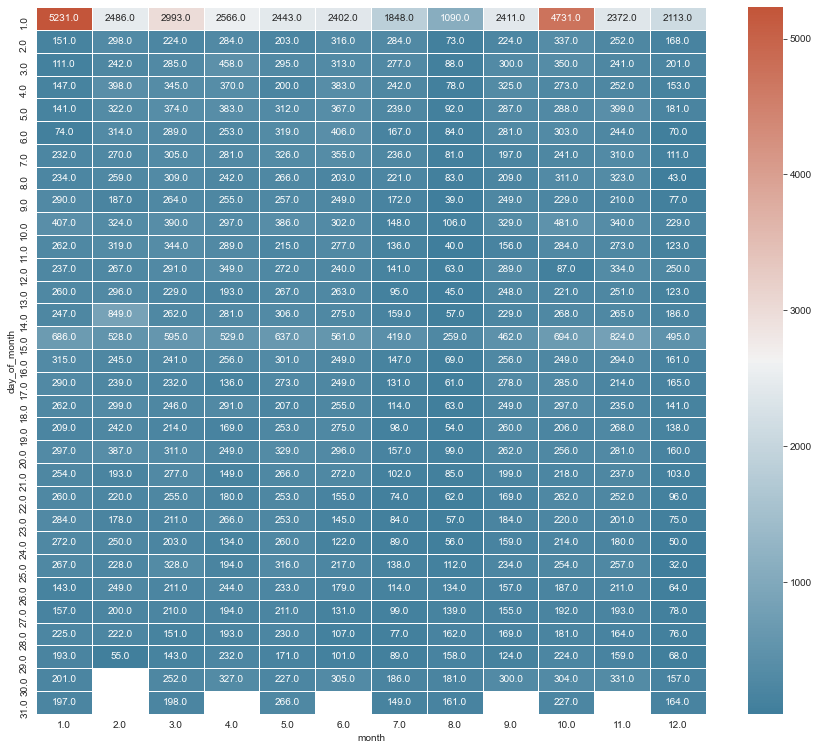

In [545]:
df_datetime_pivot = df_datetime_month.pivot("day_of_month", "month", "publication_date")

cmap = sns.diverging_palette(230, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(15, 13))
sns.heatmap(df_datetime_pivot, annot=True, fmt='', linewidths=.5, ax=ax, cmap=cmap);

### Multivariate analysis

<Figure size 936x1152 with 0 Axes>

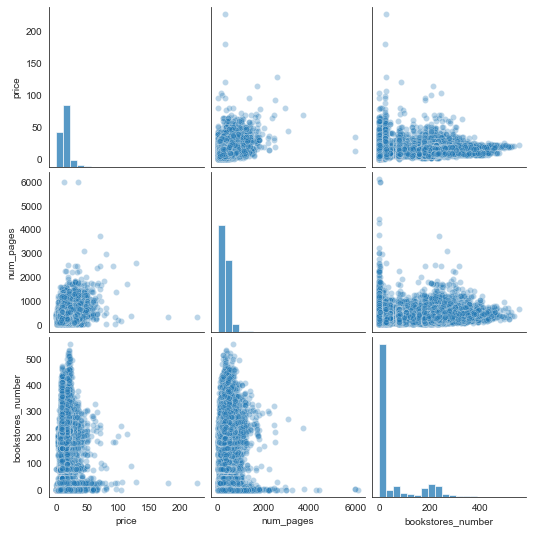

In [546]:
plt.figure(figsize=(13,16))
sns.pairplot(quantitative_df, kind='scatter', diag_kind='hist', plot_kws={'alpha':0.3}, diag_kws={'bins':20});

### Null values
- A few columns have NaN values in case the information is not available in the web site. That applies to `price`. 
- Other columns list an empty string (`original_language`, `publication_date`) or a 'None' (`img_url`) in case the information is not available.
- The variable `bookstores_number` has the value 0 when the book is not available in any of the bookshops associated with the web site.